In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('./Delight/desc-dc2')
from processSEDs import *
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
import seaborn as sns 
import itertools
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))

from delight.io import *
from delight.utils import *
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
fileName='parameters_DESC-DC2.cfg'
conf_file = os.path.realpath(os.path.join('./Delight/desc-dc2/tmp', fileName))
print(conf_file)
params = parseParamFile(conf_file, verbose=False, catFilesNeeded=False)
test_fileout_delight = params['target_catFile']
train_fileout_delight = params['training_catFile']
delight_testFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", 'Delight', 'desc-dc2', test_fileout_delight)))
print('Delight test file:\n\t{}'.format(delight_testFileoutAbs))
delight_trainFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", 'Delight', 'desc-dc2', train_fileout_delight)))

/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/Delight/desc-dc2/tmp/parameters_DESC-DC2.cfg
Delight test file:
	/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/Delight/desc-dc2/tmp/delight_data/test_gal_fluxredshifts.txt


In [3]:
processSEDs(conf_file, bias=True, k=1.0, xmin=200.)

2022-04-29 16:03:57,478 ipykernel_launcher.py, processSEDs[1844] INFO --- Process SED ---


In [4]:
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
sedNamesDelight = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'Im_B2004a', 'SB3_B2004a', 'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']
fluxredshifts = np.loadtxt(delight_testFileoutAbs)
fluxredshifts_train = np.loadtxt(delight_trainFileoutAbs)
delightUntFac=2.22e10

(7552, 14)


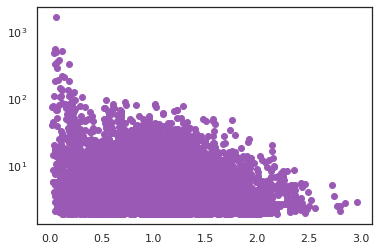

In [5]:
print(fluxredshifts.shape)
fig, ax = plt.subplots(1,1)
ax.scatter(fluxredshifts[:,-2], fluxredshifts[:,0])
ax.set_yscale('log')

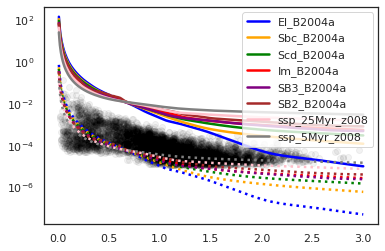

In [6]:
numFilt = 3
fig, ax = plt.subplots(1,1)
for sed, color in zip(np.arange(len(sedNamesDelight)),\
                      ['b', 'orange', 'g', 'r', 'purple', 'brown', 'pink', 'grey']):
    path = os.path.realpath(os.path.join("./", "Delight", "desc-dc2", "tmp", "data", "CWW_SEDs"))
    nameBias = sedNamesDelight[sed] + "_fluxredshiftmod-bias.txt"
    sedDataBias = np.loadtxt(os.path.join(path, nameBias))
    nameReg = sedNamesDelight[sed] + "_fluxredshiftmod.txt"
    sedDataReg = np.loadtxt(os.path.join(path, nameReg))
    ax.plot(redshiftGrid, sedDataBias[:, numFilt], c=color, label=sedNamesDelight[sed])
    ax.plot(redshiftGrid, sedDataReg[:, numFilt], c=color, ls=':')
ax.scatter(fluxredshifts[:, -2], fluxredshifts[:,numFilt*2]/np.sqrt(delightUntFac), alpha=0.05, c='k')
ax.set_yscale('log')
ax.legend()

# Schechter law fit on data

## Load DP0 data:

In [7]:
def convertformatdc2fromrail(h5file):
    """
    convertformatdc2fromrail : access to H5 file from RAIL
    
    input : H5 file descriptor
    output : datasets
    
    """
    u_mag = np.array(h5file.root.photometry.mag_u_lsst)
    g_mag = np.array(h5file.root.photometry.mag_g_lsst)
    r_mag = np.array(h5file.root.photometry.mag_r_lsst)
    i_mag = np.array(h5file.root.photometry.mag_i_lsst)
    z_mag = np.array(h5file.root.photometry.mag_z_lsst)
    y_mag = np.array(h5file.root.photometry.mag_y_lsst)
    u_err = np.array(h5file.root.photometry.mag_err_u_lsst)
    g_err = np.array(h5file.root.photometry.mag_err_g_lsst)
    r_err = np.array(h5file.root.photometry.mag_err_r_lsst)
    i_err = np.array(h5file.root.photometry.mag_err_i_lsst)
    z_err = np.array(h5file.root.photometry.mag_err_z_lsst)
    y_err = np.array(h5file.root.photometry.mag_err_y_lsst)
    z = np.array(h5file.root.photometry.redshift)
    
    
    #Photometry perturbed: doubling sizes of all errors
    #--------------------------------------------------
    u_magn = u_mag + np.sqrt(1)*u_err*np.random.randn(len(u_mag))
    g_magn = g_mag + np.sqrt(1)*g_err*np.random.randn(len(g_mag))
    r_magn = r_mag + np.sqrt(1)*r_err*np.random.randn(len(r_mag))
    i_magn = i_mag + np.sqrt(1)*i_err*np.random.randn(len(i_mag))
    z_magn = z_mag + np.sqrt(1)*z_err*np.random.randn(len(z_mag))
    y_magn = y_mag + np.sqrt(1)*y_err*np.random.randn(len(y_mag))

    
  
    # First: magnitudes only
    data_mags = np.column_stack((u_mag,g_mag,r_mag,i_mag,z_mag,y_mag))
    
    # err magnitudes only
    data_errmags = np.column_stack((u_err,g_err,r_err,i_err,z_err,y_err))
    

    # Next: colors only
    data_colors = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag))

    # Next: colors and one magnitude
    data_colmag = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag, i_mag))
    perturbed_colmag=np.column_stack((u_magn-g_magn, g_magn-r_magn, r_magn-i_magn, i_magn-z_magn, z_magn-y_magn, i_magn))

    # Finally: colors, magnitude, and size
    #data_colmagsize = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, i_mag-z_mag, z_mag-y_mag, i_mag, rad))

    
    data_z = z
    
    return data_mags,  data_errmags, data_colors, data_colmag, perturbed_colmag, data_z

def readfromdp0rsp(h5file):
    """
    convertformatdc2fromdp0rsp : access to H5 file from DP0-RSP
    
    input : H5 file descriptor
    output : datasets
    
    """
    df = pd.read_hdf(h5file,'/photoz')
    return df

m5u = 25.613 #/ 26.100
m5g = 26.678 #/ 27.400
m5r = 26.608 #/ 27.500
m5i = 25.931 #/ 26.800
m5z = 24.732 #/ 26.100
m5y = 23.954 #/ 24.900

def photodet_select(mu,mg,mr,mi,mz,my, UMAX=m5u, GMAX=m5g, RMAX = m5r, IMAX= m5i, ZMAX=m5z, YMAX=m5y):
    return (mu>17) and (mu < UMAX) and (mg < GMAX) and (mr < RMAX) and (mi < IMAX) and (mz < ZMAX) and (my < YMAX)

def selectdc2fromdp0rsp(df, Ntrain=10000):
    """
    selectfromdp0rsp : 
    
    input : dataframe
    output : datasets
    
    """
    
    # apply m5 cutoff
    df['selected'] = df.apply(lambda x:  photodet_select(x['mag_u'], x['mag_g'], x['mag_r'], x['mag_i'],x['mag_z'], x['mag_y'] ), axis=1)
    df = df[df["selected"]]
    df = df.drop('selected', axis=1)
    df = df.dropna()
    df.reset_index()
    
    Ntot = len(df)
    assert Ntot>Ntrain
    Ntest = Ntot-Ntrain
    
    
    # Test fraction
    test_sample_size_fraction=Ntest/Ntot
    test_sample_size_fraction
    
    
    # split in train/test
    target = df["redshift"]
    features = df[["mag_u","mag_g","mag_r","mag_i","mag_z","mag_y","magerr_u","magerr_g","magerr_r","magerr_i","magerr_z","magerr_y","umg","gmr","rmi","imz","zmy"]]
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_sample_size_fraction, random_state=0)
    return X_train, X_test, y_train, y_test 

In [8]:
# DP0 - DC2 extracted from Science Rubin Platform at https://data.lsst.cloud/  
# with  https://github.com/sylvielsstfr/MyDP0LSS/blob/main/09_MLscikitL_PhotoZ_part3.ipynb
inputdatadir2                  = "/sps/lsst/groups/photoz/DC2DP0"
filename_dp0dc2_h5             = "catdp0dc2_photoz_result.h5"
fullfilename_dp0dc2_h5         = os.path.join(inputdatadir2,filename_dp0dc2_h5)  

In [10]:
df = readfromdp0rsp(fullfilename_dp0dc2_h5)
X_train, X_test, y_train, y_test = selectdc2fromdp0rsp(df)
#del X_train
#del X_test

In [18]:
y_test.values

array([0.904019, 1.02505 , 0.9131  , ..., 0.291532, 1.04255 , 1.19399 ],
      dtype=float32)

In [37]:
X_test

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,magerr_u,magerr_g,magerr_r,magerr_i,magerr_z,magerr_y,umg,gmr,rmi,imz,zmy
302063,23.636175,23.528817,23.147381,22.384687,22.032331,22.021209,0.035343,0.013025,0.009842,0.008976,0.017066,0.031907,0.107358,0.381436,0.762694,0.352355,0.011122
20498,24.672198,24.994154,24.203892,23.459538,22.811797,22.624901,0.095424,0.053930,0.028421,0.026009,0.043021,0.070375,-0.321957,0.790263,0.744354,0.647741,0.186896
443975,23.390203,23.253265,22.961148,22.314799,21.980251,22.090509,0.038462,0.014444,0.012779,0.012750,0.027159,0.049168,0.136937,0.292117,0.646349,0.334548,-0.110259
373781,23.052914,23.177325,22.880353,22.328777,21.830224,21.820176,0.026150,0.011942,0.009128,0.011197,0.023918,0.037652,-0.124412,0.296973,0.551576,0.498552,0.010049
620963,23.612606,23.568759,22.884497,22.254324,22.156826,22.080307,0.040382,0.013611,0.008369,0.008627,0.021115,0.038648,0.043847,0.684262,0.630173,0.097499,0.076518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433309,22.235499,22.219872,22.360279,22.483419,22.615878,22.479896,0.010362,0.004221,0.004761,0.008962,0.027981,0.051939,0.015627,-0.140407,-0.123140,-0.132458,0.135982
188731,23.465125,23.367791,23.469326,23.447353,23.244862,22.868629,0.033329,0.013647,0.016191,0.025707,0.066728,0.086539,0.097334,-0.101535,0.021973,0.202490,0.376233
202296,25.071650,24.532997,23.792667,23.295712,23.199517,23.175403,0.124929,0.032257,0.017785,0.023677,0.050545,0.100140,0.538653,0.740330,0.496955,0.096195,0.024115
497155,22.587643,22.623196,22.410919,21.948934,21.353675,21.221684,0.016653,0.007019,0.005835,0.006867,0.011749,0.018187,-0.035553,0.212276,0.461985,0.595259,0.131991


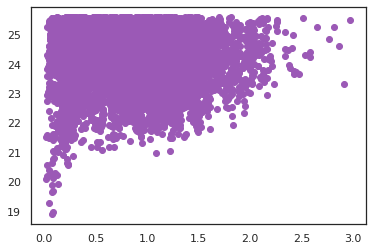

In [23]:
plt.scatter(y_train.values,X_train["mag_u"].values)

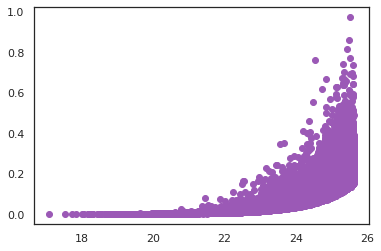

In [25]:
plt.scatter(X_test["mag_u"].values, X_test["magerr_u"].values)

In [30]:
mag_inf, mag_sup = 17.0, 18.0
nbGal = len([x for x in X_test["mag_u"].values if (x >= mag_inf and x < mag_sup) ])

In [31]:
print(nbGal)

4


In [36]:
mag_bins = np.linspace(np.min(X_test["mag_u"].values), np.max(X_test["mag_u"].values), 50)
nbGalList = []
nbTot = 0
for mag_inf, mag_sup in zip(mag_bins[0:-1], mag_bins[1:]):
    nbGal = len([x for x in X_test["mag_u"].values if (x >= mag_inf and x < mag_sup) ])
    print(mag_inf, mag_sup, nbGal)
    nbTot += nbGal
    nbGalList.append(nbGal)
nbGalList

17.1014831 17.27518693265306 1
17.27518693265306 17.44889076530612 0
17.44889076530612 17.622594597959182 1
17.622594597959182 17.796298430612243 1
17.796298430612243 17.970002263265307 1
17.970002263265307 18.14370609591837 2
18.14370609591837 18.31740992857143 8
18.31740992857143 18.49111376122449 2
18.49111376122449 18.66481759387755 5
18.66481759387755 18.838521426530612 11
18.838521426530612 19.012225259183673 15
19.012225259183673 19.185929091836734 7
19.185929091836734 19.359632924489794 12
19.359632924489794 19.533336757142855 12
19.533336757142855 19.707040589795916 23
19.707040589795916 19.88074442244898 25
19.88074442244898 20.05444825510204 37
20.05444825510204 20.228152087755102 37
20.228152087755102 20.401855920408163 51
20.401855920408163 20.575559753061224 62
20.575559753061224 20.749263585714285 82
20.749263585714285 20.922967418367346 85
20.922967418367346 21.096671251020407 132
21.096671251020407 21.27037508367347 192
21.27037508367347 21.444078916326532 307
21.44407

[1,
 0,
 1,
 1,
 1,
 2,
 8,
 2,
 5,
 11,
 15,
 7,
 12,
 12,
 23,
 25,
 37,
 37,
 51,
 62,
 82,
 85,
 132,
 192,
 307,
 431,
 640,
 914,
 1313,
 1739,
 2322,
 2972,
 3656,
 4365,
 5072,
 5797,
 6406,
 7248,
 8242,
 9035,
 10258,
 12469,
 14090,
 14539,
 13900,
 13594,
 13035,
 12704,
 12208]

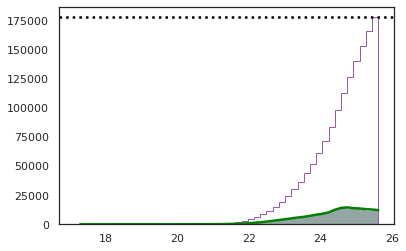

In [47]:
plt.hist(X_test["mag_u"].values, bins=mag_bins, cumulative=True, histtype='step')
plt.hist(X_test["mag_u"].values, bins=mag_bins, cumulative=False, histtype='stepfilled')
plt.axhline(nbTot, c='k', ls=":")
plt.plot(mag_bins[1:],nbGalList, c="g")

In [120]:
phistar=1.1
mstar=25
alpha=-0.6
k=alpha+1
phi = lambda m : 0.4*np.log(10)*phistar * \
                np.power(10, 0.4*(alpha+1.)*(m - mstar)) * \
                np.exp(-np.power(10, 0.4*(m - mstar)))

[]

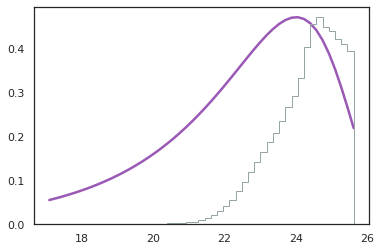

In [121]:
plt.plot(mag_bins, phi(mag_bins))
plt.hist(X_test["mag_u"].values, bins=mag_bins, cumulative=False, histtype='step', density=True)
plt.plot()